### 1. Inicjalizacja YOLO-Medium i ścieżek

In [1]:
### 1. Inicjalizacja YOLO-Medium i ścieżek

from pathlib import Path
import torch
from ultralytics import YOLO

# urządzenie (Apple Silicon → mps; fallback → cpu)
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

# korzeń projektu
PROJECT_ROOT = Path(".").resolve()

# katalog wejściowy ze zdjęciami
IMAGE_ROOT = PROJECT_ROOT / "inputs"
IMAGE_ROOT.mkdir(exist_ok=True)

# katalog wynikowy
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "yolo_medium"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("IMAGE_ROOT:", IMAGE_ROOT)
print("OUTPUT_DIR:", OUTPUT_DIR)

# ładowanie modelu YOLO-Medium (COCO pretrained)
model = YOLO("yolov8m.pt")
model.to(device)
print("Załadowano YOLO-Medium (yolov8m.pt)")

Device: mps
PROJECT_ROOT: /Users/olga/MetaLogic
IMAGE_ROOT: /Users/olga/MetaLogic/inputs
OUTPUT_DIR: /Users/olga/MetaLogic/outputs/yolo_medium


100%|██████████| 49.7M/49.7M [00:01<00:00, 26.4MB/s]


Załadowano YOLO-Medium (yolov8m.pt)


### 2. Funkcja detekcji dla pojedynczego obrazu

In [5]:
### 2. Lista obrazów wejściowych

from pathlib import Path

PROJECT_ROOT = Path(".").resolve()
IMAGE_ROOT = PROJECT_ROOT / "inputs"

# lista plików graficznych (bez .DS_Store)
image_files = sorted([
    p for p in IMAGE_ROOT.iterdir()
    if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".tif", ".tiff"]
])

print("Liczba obrazów:", len(image_files))
if len(image_files) == 0:
    print("UWAGA: brak obrazów w folderze 'inputs/'")

Liczba obrazów: 50


### 3. Wizualizacja detekcji (rysowanie bounding boxów)


0: 640x416 21 bottles, 153.7ms
Speed: 2.0ms preprocess, 153.7ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 416)


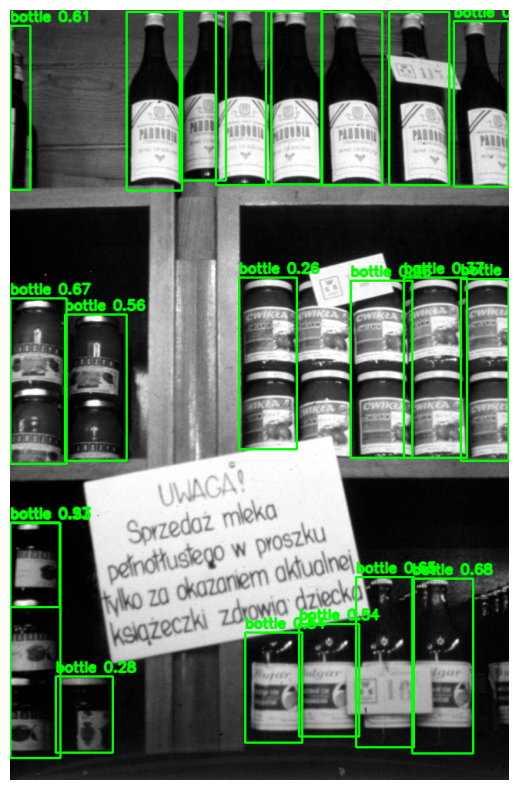

In [7]:
### 3. Wczytywanie modelu YOLO-Medium i funkcje pomocnicze

import torch
import numpy as np
from ultralytics import YOLO
import cv2
from PIL import Image

# Załaduj YOLO-Medium (yolov8m)
model = YOLO("yolov8m.pt")  # medium

# nazwy klas COCO:  {0: 'person', 1: 'bicycle', ...}
CLASS_NAMES = model.names

def run_yolo_on_image(img_path):
    """Wczytuje obraz i wykonuje detekcję YOLO-Medium."""
    img = Image.open(img_path).convert("RGB")
    results = model(img, conf=0.25)[0]
    detections = results.boxes
    return img, detections


def draw_detections(orig_img, detections):
    """Rysuje wykryte obiekty na obrazie."""
    img_np = np.array(orig_img).copy()

    for b in detections:
        cls_id = int(b.cls)
        conf = float(b.conf)
        x1, y1, x2, y2 = map(int, b.xyxy[0])

        # zielony box
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)

        label = f"{CLASS_NAMES[cls_id]} {conf:.2f}"
        cv2.putText(
            img_np,
            label,
            (x1, y1 - 6),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

    return Image.fromarray(img_np)


# test jednego obrazu
test_img = image_files[0]
orig, dets = run_yolo_on_image(test_img)
vis = draw_detections(orig, dets)

plt.figure(figsize=(10, 10))
plt.imshow(vis)
plt.axis("off")
plt.show()

### 4. Batch YOLO-Medium inference → zapis wyników do CSV

In [8]:
### 4. Batch YOLO-Medium inference → zapis wyników do CSV

import pandas as pd
from tqdm import tqdm

OUTPUT_CSV = OUTPUT_DIR / "yolo_medium_results.csv"

records = []

for img_path in tqdm(image_files, desc="YOLO-Medium batch", ncols=90):
    try:
        orig, dets = run_yolo_on_image(img_path)
    except Exception:
        continue

    class_ids = [int(b.cls) for b in dets]
    class_names = [CLASS_NAMES[c] for c in class_ids]

    # zliczamy ile obiektów danej klasy
    counts = pd.Series(class_names).value_counts().to_dict()

    records.append({
        "file_path": str(img_path),
        "n_detections": len(class_names),
        "classes": class_names,
        "class_counts": counts,
    })

df_yolo = pd.DataFrame(records)

df_yolo.to_csv(OUTPUT_CSV, index=False)
print("Zapisano wyniki:", OUTPUT_CSV)
print("Liczba obrazów przetworzonych:", len(df_yolo))

YOLO-Medium batch:   0%|                                           | 0/50 [00:00<?, ?it/s]


0: 640x416 21 bottles, 143.2ms
Speed: 1.7ms preprocess, 143.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


YOLO-Medium batch:   2%|▋                                  | 1/50 [00:00<00:07,  6.30it/s]


0: 480x640 16 persons, 1 tie, 145.4ms
Speed: 1.2ms preprocess, 145.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   4%|█▍                                 | 2/50 [00:00<00:07,  6.25it/s]


0: 480x640 15 persons, 142.1ms
Speed: 1.5ms preprocess, 142.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   6%|██                                 | 3/50 [00:00<00:07,  6.31it/s]


0: 480x640 19 persons, 1 tie, 1 tennis racket, 142.1ms
Speed: 1.4ms preprocess, 142.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   8%|██▊                                | 4/50 [00:00<00:07,  6.32it/s]


0: 480x640 12 persons, 1 backpack, 1 handbag, 1 potted plant, 143.1ms
Speed: 1.7ms preprocess, 143.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  10%|███▌                               | 5/50 [00:00<00:07,  6.32it/s]


0: 448x640 13 persons, 1 bench, 1 handbag, 144.7ms
Speed: 1.2ms preprocess, 144.7ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  12%|████▏                              | 6/50 [00:00<00:07,  6.16it/s]


0: 448x640 4 persons, 1 dog, 1 handbag, 143.5ms
Speed: 1.2ms preprocess, 143.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  14%|████▉                              | 7/50 [00:01<00:07,  6.05it/s]


0: 576x640 11 persons, 2 motorcycles, 171.6ms
Speed: 1.6ms preprocess, 171.6ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  16%|█████▌                             | 8/50 [00:01<00:08,  5.16it/s]


0: 448x640 18 persons, 1 tie, 148.3ms
Speed: 1.1ms preprocess, 148.3ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  18%|██████▎                            | 9/50 [00:01<00:07,  5.40it/s]


0: 448x640 17 persons, 5 cars, 3 buss, 1 backpack, 3 handbags, 140.1ms
Speed: 1.1ms preprocess, 140.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  20%|██████▊                           | 10/50 [00:01<00:07,  5.65it/s]


0: 512x640 3 persons, 1 tie, 13 donuts, 5 cakes, 176.0ms
Speed: 1.6ms preprocess, 176.0ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  22%|███████▍                          | 11/50 [00:02<00:08,  4.58it/s]


0: 640x640 5 persons, 1 bicycle, 1 bowl, 198.5ms
Speed: 1.6ms preprocess, 198.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  24%|████████▏                         | 12/50 [00:02<00:08,  4.47it/s]


0: 544x640 18 persons, 4 cars, 1 truck, 7 umbrellas, 1 handbag, 1 potted plant, 161.0ms
Speed: 1.6ms preprocess, 161.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  26%|████████▊                         | 13/50 [00:02<00:08,  4.27it/s]


0: 640x640 10 persons, 3 handbags, 193.8ms
Speed: 1.6ms preprocess, 193.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  28%|█████████▌                        | 14/50 [00:02<00:08,  4.29it/s]


0: 512x640 9 persons, 167.6ms
Speed: 1.4ms preprocess, 167.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  30%|██████████▏                       | 15/50 [00:02<00:07,  4.57it/s]


0: 576x640 6 persons, 1 car, 1 dog, 1 sports ball, 2 cups, 164.8ms
Speed: 1.6ms preprocess, 164.8ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  32%|██████████▉                       | 16/50 [00:03<00:07,  4.45it/s]


0: 544x640 10 persons, 1 bicycle, 1 car, 4 benchs, 154.5ms
Speed: 1.5ms preprocess, 154.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  34%|███████████▌                      | 17/50 [00:03<00:07,  4.30it/s]


0: 544x640 5 persons, 1 bicycle, 4 benchs, 1 suitcase, 156.6ms
Speed: 1.6ms preprocess, 156.6ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  36%|████████████▏                     | 18/50 [00:03<00:07,  4.17it/s]


0: 608x640 4 persons, 2 handbags, 1 bottle, 2 cell phones, 174.7ms
Speed: 1.6ms preprocess, 174.7ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  38%|████████████▉                     | 19/50 [00:03<00:07,  4.06it/s]


0: 512x640 9 persons, 1 car, 3 buss, 1 truck, 165.2ms
Speed: 1.5ms preprocess, 165.2ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  40%|█████████████▌                    | 20/50 [00:04<00:07,  3.95it/s]


0: 640x608 6 persons, 1 bus, 211.0ms
Speed: 1.7ms preprocess, 211.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 608)


YOLO-Medium batch:  42%|██████████████▎                   | 21/50 [00:04<00:07,  3.87it/s]


0: 640x512 1 person, 165.7ms
Speed: 1.4ms preprocess, 165.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  44%|██████████████▉                   | 22/50 [00:04<00:07,  4.00it/s]


0: 640x480 2 persons, 1 bicycle, 139.4ms
Speed: 1.3ms preprocess, 139.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  46%|███████████████▋                  | 23/50 [00:04<00:05,  4.54it/s]


0: 512x640 1 person, 1 bear, 1 sink, 1 scissors, 165.9ms
Speed: 1.5ms preprocess, 165.9ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  48%|████████████████▎                 | 24/50 [00:05<00:06,  4.21it/s]


0: 576x640 3 persons, 1 tie, 1 suitcase, 164.6ms
Speed: 2.0ms preprocess, 164.6ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  50%|█████████████████                 | 25/50 [00:05<00:05,  4.19it/s]


0: 640x640 7 persons, 1 handbag, 1 suitcase, 188.3ms
Speed: 1.7ms preprocess, 188.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  52%|█████████████████▋                | 26/50 [00:05<00:05,  4.04it/s]


0: 640x640 10 persons, 1 handbag, 190.0ms
Speed: 1.6ms preprocess, 190.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  54%|██████████████████▎               | 27/50 [00:05<00:05,  4.14it/s]


0: 640x640 4 persons, 1 fork, 1 bowl, 1 chair, 188.4ms
Speed: 1.6ms preprocess, 188.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  56%|███████████████████               | 28/50 [00:06<00:05,  4.21it/s]


0: 640x640 1 person, 1 umbrella, 3 bottles, 2 clocks, 189.6ms
Speed: 1.7ms preprocess, 189.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  58%|███████████████████▋              | 29/50 [00:06<00:04,  4.22it/s]


0: 640x640 10 persons, 3 bicycles, 1 bottle, 190.6ms
Speed: 1.7ms preprocess, 190.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  60%|████████████████████▍             | 30/50 [00:06<00:04,  4.08it/s]


0: 480x640 1 sheep, 139.3ms
Speed: 1.2ms preprocess, 139.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  62%|█████████████████████             | 31/50 [00:06<00:04,  4.62it/s]


0: 640x480 4 persons, 1 dog, 1 sheep, 1 sports ball, 177.9ms
Speed: 1.3ms preprocess, 177.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  64%|█████████████████████▊            | 32/50 [00:06<00:03,  4.79it/s]


0: 640x640 6 persons, 188.3ms
Speed: 1.8ms preprocess, 188.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  66%|██████████████████████▍           | 33/50 [00:07<00:03,  4.70it/s]


0: 640x480 2 persons, 1 tie, 8 bottles, 138.0ms
Speed: 1.6ms preprocess, 138.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  68%|███████████████████████           | 34/50 [00:07<00:03,  4.78it/s]


0: 512x640 8 persons, 2 sheeps, 165.7ms
Speed: 1.5ms preprocess, 165.7ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  70%|███████████████████████▊          | 35/50 [00:07<00:03,  4.64it/s]


0: 640x512 3 persons, 168.2ms
Speed: 1.5ms preprocess, 168.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  72%|████████████████████████▍         | 36/50 [00:07<00:02,  4.88it/s]


0: 480x640 3 persons, 1 train, 139.0ms
Speed: 1.1ms preprocess, 139.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  74%|█████████████████████████▏        | 37/50 [00:07<00:02,  5.31it/s]


0: 416x640 3 persons, 1 horse, 128.5ms
Speed: 1.5ms preprocess, 128.5ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  76%|█████████████████████████▊        | 38/50 [00:08<00:02,  5.74it/s]


0: 608x640 2 persons, 173.7ms
Speed: 1.8ms preprocess, 173.7ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  78%|██████████████████████████▌       | 39/50 [00:08<00:02,  5.08it/s]


0: 640x448 1 person, 140.9ms
Speed: 1.3ms preprocess, 140.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  80%|███████████████████████████▏      | 40/50 [00:08<00:01,  5.44it/s]


0: 512x640 2 persons, 2 horses, 166.3ms
Speed: 1.9ms preprocess, 166.3ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  82%|███████████████████████████▉      | 41/50 [00:08<00:01,  5.45it/s]


0: 576x640 4 persons, 3 cups, 1 bowl, 163.9ms
Speed: 1.6ms preprocess, 163.9ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  84%|████████████████████████████▌     | 42/50 [00:08<00:01,  4.75it/s]


0: 576x640 3 persons, 2 birds, 2 cups, 1 bowl, 202.1ms
Speed: 1.6ms preprocess, 202.1ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  86%|█████████████████████████████▏    | 43/50 [00:09<00:01,  4.16it/s]


0: 512x640 2 persons, 2 suitcases, 4 cups, 1 tv, 166.7ms
Speed: 1.6ms preprocess, 166.7ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  88%|█████████████████████████████▉    | 44/50 [00:09<00:01,  3.91it/s]


0: 640x640 2 persons, 1 bed, 190.4ms
Speed: 1.7ms preprocess, 190.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  90%|██████████████████████████████▌   | 45/50 [00:09<00:01,  3.97it/s]


0: 640x640 2 persons, 1 donut, 188.5ms
Speed: 1.7ms preprocess, 188.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  92%|███████████████████████████████▎  | 46/50 [00:10<00:00,  4.02it/s]


0: 640x640 2 persons, 1 tie, 2 bowls, 1 laptop, 1 oven, 2 books, 188.7ms
Speed: 1.7ms preprocess, 188.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  94%|███████████████████████████████▉  | 47/50 [00:10<00:00,  4.06it/s]


0: 640x640 29 persons, 1 car, 1 handbag, 1 clock, 189.0ms
Speed: 1.6ms preprocess, 189.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  96%|████████████████████████████████▋ | 48/50 [00:10<00:00,  4.18it/s]


0: 640x640 7 persons, 2 handbags, 187.9ms
Speed: 1.7ms preprocess, 187.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  98%|█████████████████████████████████▎| 49/50 [00:10<00:00,  4.02it/s]


0: 640x640 1 person, 13 donuts, 191.0ms
Speed: 1.6ms preprocess, 191.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch: 100%|██████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]

Zapisano wyniki: /Users/olga/MetaLogic/outputs/yolo_medium/yolo_medium_results.csv
Liczba obrazów przetworzonych: 50


### 5. Podsumowanie detekcji + wizualizacja 5 przykładów

=== Podsumowanie detekcji w całym folderze ===
person: 335
bottle: 34
donut: 27
handbag: 17
car: 13
cup: 11
bench: 9
umbrella: 8
bus: 7
bicycle: 7
tie: 7
bowl: 6
cake: 5
suitcase: 5
sheep: 4
dog: 3
horse: 3
clock: 3
backpack: 2
book: 2
bird: 2
cell phone: 2
sports ball: 2
truck: 2
potted plant: 2
motorcycle: 2
sink: 1
bear: 1
scissors: 1
fork: 1
chair: 1
train: 1
tennis racket: 1
tv: 1
bed: 1
oven: 1
laptop: 1

Wybrane przykładowe obrazy: ['/Users/olga/MetaLogic/inputs/0282.jpg', '/Users/olga/MetaLogic/inputs/0115.jpg', '/Users/olga/MetaLogic/inputs/0077.jpg', '/Users/olga/MetaLogic/inputs/0106.jpg', '/Users/olga/MetaLogic/inputs/0004.jpg']

0: 640x640 29 persons, 1 car, 1 handbag, 1 clock, 253.9ms
Speed: 3.7ms preprocess, 253.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 18 persons, 4 cars, 1 truck, 7 umbrellas, 1 handbag, 1 potted plant, 159.8ms
Speed: 1.5ms preprocess, 159.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

0: 448

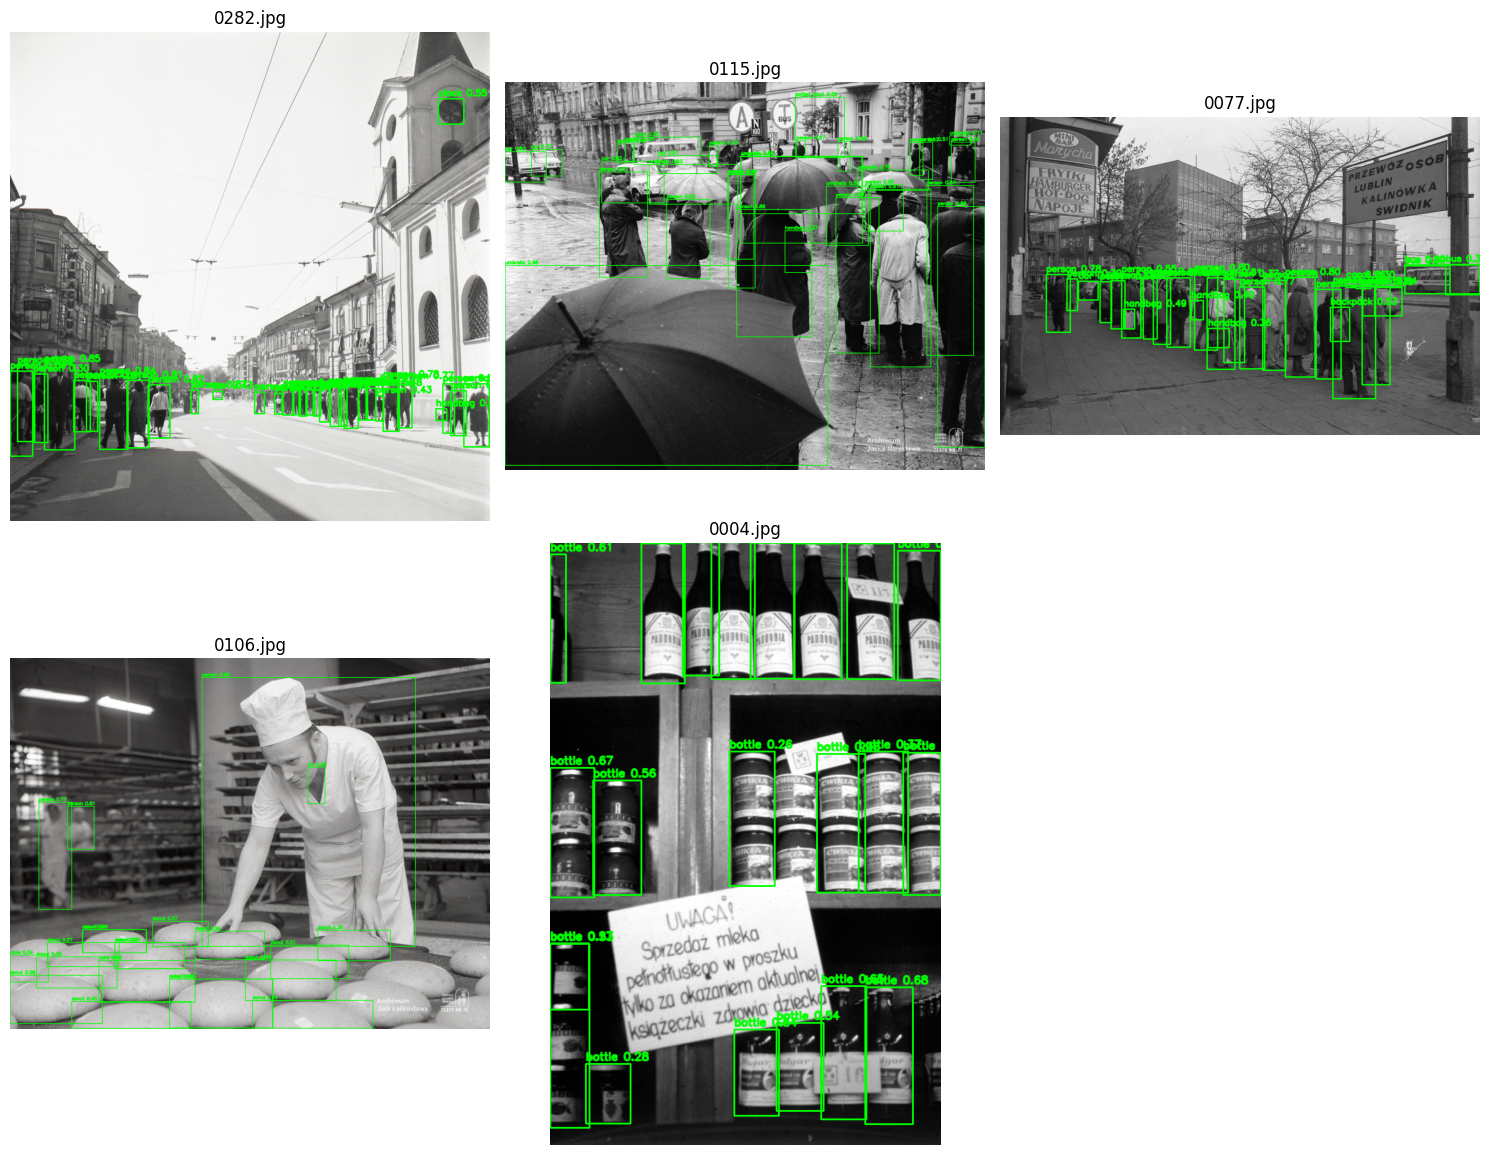

In [9]:
### 5. Podsumowanie detekcji + wizualizacja 5 przykładów

import matplotlib.pyplot as plt
import numpy as np

# --- globalne podsumowanie klas ---
all_counts = {}

for counts in df_yolo["class_counts"]:
    for cls, n in counts.items():
        all_counts[cls] = all_counts.get(cls, 0) + n

summary = pd.Series(all_counts).sort_values(ascending=False)

print("=== Podsumowanie detekcji w całym folderze ===")
for cls, n in summary.items():
    print(f"{cls}: {n}")

# --- wybieramy 5 obrazów z największą liczbą detekcji ---
examples = (
    df_yolo.sort_values("n_detections", ascending=False)
           .head(5)
)["file_path"].tolist()

print("\nWybrane przykładowe obrazy:", examples)

# --- wizualizacja ---
plt.figure(figsize=(15, 12))

for i, img_path in enumerate(examples, start=1):
    orig, dets = run_yolo_on_image(img_path)
    vis = draw_detections(orig, dets)

    plt.subplot(2, 3, i)
    plt.imshow(vis)
    plt.title(Path(img_path).name)
    plt.axis("off")

plt.tight_layout()
plt.show()

### X. Eksport wykrytych obiektów do CSV

In [13]:
### X. Sugestie subject (PL/EN) na podstawie YOLO i eksport do CSV

import pandas as pd
from ast import literal_eval

# plik z batchowym wynikiem YOLO (komórka 4)
RESULTS_CSV = OUTPUT_DIR / "yolo_medium_results.csv"

# ============================
# SŁOWNIK EN → PL DLA KLAS YOLO
# (rozszerzysz w razie potrzeby)
# ============================
CLASS_PL = {
    "person": "osoba",
    "car": "samochód",
    "bicycle": "rower",
    "bus": "autobus",
    "truck": "ciężarówka",
    "train": "pociąg",
    "motorcycle": "motocykl",
    "bench": "ławka",
    "traffic light": "sygnalizator świetlny",
    "stop sign": "znak stop",
    "backpack": "plecak",
    "handbag": "torebka",
    "bottle": "butelka",
    "potted plant": "roślina w doniczce",
    "tennis racket": "rakieta tenisowa",
    # dopisuj kolejne klasy wg potrzeb
}

# 1) wczytanie wyników YOLO (jeśli df_yolo nie jest w pamięci)
if "df_yolo" not in globals():
    if not RESULTS_CSV.exists():
        raise FileNotFoundError(f"Brak pliku: {RESULTS_CSV}")
    df_yolo = pd.read_csv(
        RESULTS_CSV,
        converters={
            "classes": literal_eval,      # listy klas
            "class_counts": literal_eval  # słowniki {klasa: liczba}
        }
    )

# 2) funkcja: listę klas EN → subject_en + subject_pl
def classes_to_subjects(class_list):
    if not isinstance(class_list, list):
        return pd.Series({"subject_en": "", "subject_pl": ""})

    unique_en = sorted(set(class_list))
    subject_en = "; ".join(unique_en)

    pl_names = [CLASS_PL[c] for c in unique_en if c in CLASS_PL]
    subject_pl = "; ".join(pl_names) if pl_names else ""

    return pd.Series({"subject_en": subject_en, "subject_pl": subject_pl})

# 3) agregacja: jedno zdjęcie → jedna para subject_en / subject_pl
df_subj = df_yolo[["file_path", "classes"]].copy()
subj_cols = df_subj["classes"].apply(classes_to_subjects)
df_subj = pd.concat([df_subj["file_path"], subj_cols], axis=1)

# 4) zapis CSV
SUBJECT_CSV = OUTPUT_DIR / "yolo_subject_suggestions.csv"
df_subj.to_csv(SUBJECT_CSV, index=False)

print("Zapisano sugestie subject do:", SUBJECT_CSV)
df_subj.head()

Zapisano sugestie subject do: /Users/olga/MetaLogic/outputs/yolo_medium/yolo_subject_suggestions.csv


,file_path,subject_en,subject_pl
0,/Users/olga/MetaLogic/inputs/0004.jpg,bottle,butelka
1,/Users/olga/MetaLogic/inputs/0006.jpg,person; tie,osoba
2,/Users/olga/MetaLogic/inputs/0009.jpg,person,osoba
3,/Users/olga/MetaLogic/inputs/0022.jpg,person; tennis racket; tie,osoba; rakieta tenisowa
4,/Users/olga/MetaLogic/inputs/0034.jpg,backpack; handbag; person; potted plant,plecak; torebka; osoba; roślina w doniczce


### Nota: trening YOLO dla własnych obiektów

Aby wytrenować YOLO (m/l) do wykrywania obiektów typu *Syrena*, *kiosk RUCH*:

- zdefiniuj klasy (np. `syrena`, `kiosk_ruch`)
- zbierz zdjęcia (200–500/klasę; dla rzadkich obiektów 100–200 może wystarczyć; zdjęcia z internetu do użytku wewnętrznego są OK)
- wykonaj ręczną anotację bounding boxów w Label Studio (eksport: YOLO TXT)
- przygotuj strukturę datasetu:

        dataset/images/train, val
        dataset/labels/train, val

- utwórz `data.yaml` (ścieżki + lista klas)
- trenuj:

        yolo detect train model=yolo11m.pt data=data.yaml imgsz=1024 epochs=100